In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

import ta
from ta import add_all_ta_features
from ta.utils import dropna

### 1. Read and visualize dataset

In [2]:
datasets = ['ali', 'copper', 'lead', 'nickel', 'zinc']

df = pd.DataFrame()
for idx, metal in enumerate(datasets):
    dataset_file = "./Data/{}.csv".format(metal)
    df_1 = pd.read_csv(dataset_file, index_col=0)
    df_1['date'] = pd.to_datetime(df_1['date'])
    df_1.set_index('date', drop=True, inplace=True)
    df_1.columns = [col + '_' + metal for col in df_1.columns]
    df = df.join(df_1, how='outer')
df[df.isna().any(axis=1)]

,PX_LAST_ali,PX_HIGH_ali,PX_LOW_ali,PX_OPEN_ali,PX_VOLUME_ali,PX_LAST_copper,PX_HIGH_copper,PX_LOW_copper,PX_OPEN_copper,PX_VOLUME_copper,...,PX_LAST_nickel,PX_HIGH_nickel,PX_LOW_nickel,PX_OPEN_nickel,PX_VOLUME_nickel,PX_LAST_zinc,PX_HIGH_zinc,PX_LOW_zinc,PX_OPEN_zinc,PX_VOLUME_zinc
date,,,,,,,,,,,,,,,,,,,,,
2018-12-25,1883.0,1883.0,1883.0,1883.0,NaN,5959.0,5959.0,5959.0,5959.0,NaN,...,10875.0,10875.0,10875.0,10875.0,NaN,2485.0,2485.0,2485.0,2485.0,NaN
2019-01-01,1853.0,1853.0,1853.0,1853.0,NaN,5912.0,5912.0,5912.0,5912.0,NaN,...,10645.0,10645.0,10645.0,10645.0,NaN,2454.0,2454.0,2454.0,2454.0,NaN
2022-03-08,3681.0,3900.0,3434.0,3740.0,32473.0,10334.5,10764.5,10011.0,10266.5,22072.0,...,NaN,NaN,NaN,NaN,NaN,4250.5,4896.0,3900.0,4134.0,19417.0
2022-03-09,3301.0,3680.0,3300.0,3680.0,21544.0,9977.0,10345.0,9947.0,10335.5,13316.0,...,NaN,NaN,NaN,NaN,NaN,3840.0,4250.0,3836.0,4250.0,13437.0
2022-03-10,3400.0,3557.5,3302.0,3302.0,18306.0,10130.0,10194.5,9967.0,9967.0,9365.0,...,NaN,NaN,NaN,NaN,NaN,3830.0,3972.5,3785.0,3884.0,6843.0
2022-03-11,3480.0,3515.0,3387.5,3400.0,11310.0,10101.0,10337.0,10080.0,10125.0,8390.0,...,NaN,NaN,NaN,NaN,NaN,3830.0,3899.5,3806.0,3838.0,4813.0
2022-03-14,3315.0,3497.0,3302.0,3497.0,12951.0,9887.5,10100.0,9866.0,10078.5,15633.0,...,NaN,NaN,NaN,NaN,NaN,3809.0,3872.0,3744.0,3814.0,5604.0
2022-03-15,3299.0,3351.5,3219.5,3315.0,15508.0,9892.0,9978.0,9820.0,9888.0,14594.0,...,NaN,NaN,NaN,NaN,NaN,3794.5,3824.0,3736.0,3792.0,6674.0


In [3]:
# Clean NaN values
df.dropna(inplace=True)

for col in df.columns:
    df[col] = df[col].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5438 entries, 2004-01-02 to 2025-07-18
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PX_LAST_ali       5438 non-null   float64
 1   PX_HIGH_ali       5438 non-null   float64
 2   PX_LOW_ali        5438 non-null   float64
 3   PX_OPEN_ali       5438 non-null   float64
 4   PX_VOLUME_ali     5438 non-null   float64
 5   PX_LAST_copper    5438 non-null   float64
 6   PX_HIGH_copper    5438 non-null   float64
 7   PX_LOW_copper     5438 non-null   float64
 8   PX_OPEN_copper    5438 non-null   float64
 9   PX_VOLUME_copper  5438 non-null   float64
 10  PX_LAST_lead      5438 non-null   float64
 11  PX_HIGH_lead      5438 non-null   float64
 12  PX_LOW_lead       5438 non-null   float64
 13  PX_OPEN_lead      5438 non-null   float64
 14  PX_VOLUME_lead    5438 non-null   float64
 15  PX_LAST_nickel    5438 non-null   float64
 16  PX_HIGH_nickel    5438 n

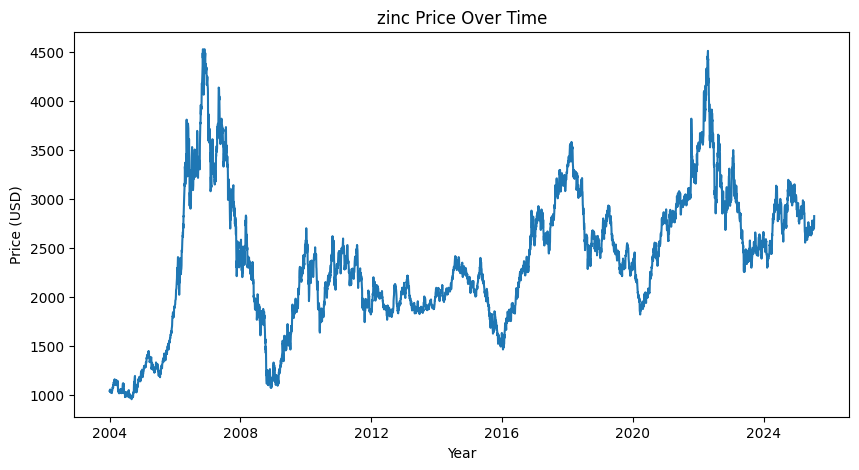

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df['PX_LAST_{}'.format(metal)])
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.title("{} Price Over Time".format(metal))
plt.show()

### 2. PCA feature selection (PASS)

In [94]:
# X = df.drop(columns=['PX_LAST', 'PX_HIGH', 'PX_LOW', 'PX_OPEN', 'PX_VOLUME'])

# scalar = StandardScaler()
# X_scaled = scalar.fit_transform(X)

In [95]:
# pca = PCA(n_components = X.shape[1])
# X_pca = pca.fit_transform(X_scaled)
# explained_variance = pca.explained_variance_ratio_
# for i, v in enumerate(np.cumsum(explained_variance)):
#     if v > 0.9:
#         break

# loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_)).iloc[:, :i+1]

# n = int(X.shape[1] * 0.1)
# l_idx = []
# for col in loadings.columns:
#     l_idx += list(loadings.nlargest(n, columns=col).index)

# selected_features = X.iloc[:, list(set(l_idx))].columns
# print(len(selected_features))

23


### 3. Data processing for modeling

In [5]:
X = df.drop(columns=['PX_LAST_{}'.format(metal) for metal in datasets])
y = df[['PX_LAST_{}'.format(metal) for metal in datasets]]

X.shape, y.shape

((5438, 20), (5438, 5))

In [6]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix:out_end_ix]
        X.append(seq_x), y.append(seq_y.flatten())
    return np.array(X), np.array(y)

In [7]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y)

# Use input sequence of 30 to predict 10-day return
X_ss, y_mm = split_sequences(X_trans, y_trans, 30, 10)
X_res, y_res = split_sequences(X_trans, y_trans, 30, 0)

print(X_trans.shape, y_trans.shape, X_ss.shape, y_mm.shape)

(5438, 20) (5438, 5) (5399, 30, 20) (5399, 50)


In [8]:
total_samples = len(X)
train_test_cutoff = round(0.95 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]
X_pred = X_res[-10:-1]
X_last = X_res[-1]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (5166, 30, 20) (5166, 50)
Testing Shape: (233, 30, 20) (233, 50)


In [9]:
# convert to pytorch tensors
df_X_ss = torch.Tensor(X_ss)
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)
X_pred_tensors = torch.Tensor(X_pred)
X_last_tensor = torch.Tensor(X_last).unsqueeze(0)

df_y_mm = torch.Tensor(y_mm)
y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [10]:
# reshape to rows, timestamps, features
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 30, df_X_ss.shape[2]))
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 30, X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 30, X_test_tensors.shape[2]))
X_pred_tensors_final = torch.reshape(X_pred_tensors, (X_pred_tensors.shape[0], 30, X_pred_tensors.shape[2]))
X_last_tensor_final = torch.reshape(X_last_tensor, (X_last_tensor.shape[0], 30, X_last_tensor.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([5166, 30, 20]) torch.Size([5166, 50])
Testing Shape: torch.Size([233, 30, 20]) torch.Size([233, 50])


In [11]:
print(X_pred_tensors_final.shape, X_last_tensor_final.shape)

torch.Size([9, 30, 20]) torch.Size([1, 30, 20])


### 4. LSTM model

In [16]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.dropout_probability = 0.5
        # LSTM model
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=num_layers, batch_first=True) # lstm
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                             num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm1(x, (h_0, c_0)) # (input, hidden, and internal state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output, (hn, cn) = self.lstm2(output, (h_0, c_0))
        output = F.dropout(output, p=self.dropout_probability, training=True)

        # Important when lstm num_layers > 1
        last_layer_hn = hn[-1, :, :]
        flattened_output = last_layer_hn.view(last_layer_hn.size(0), -1)
        # hn = hn.view(-1, self.hidden_size) # reshape the data for Dense layer next
        
        out = self.relu(flattened_output)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [17]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train,
                  X_test, y_test):

    # Initialize a list to log training/validation losses
    train_loss_logger = []
    val_loss_logger = []
    
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        
        # calculate loss
        loss = loss_fn(outputs, y_train)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        # Log the training loss
        train_loss_logger.append(loss.item())
        
        # validation loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)

        # Log the validation loss
        val_loss_logger.append(test_loss.item())
        
        if epoch % 50 == 0:
            print(f"Epoch: {epoch}, train loss: {loss.item(): .5f}, test loss: {test_loss.item(): .5f}" )

    return train_loss_logger, val_loss_logger

#### 4.1 Define hyperparameters

In [18]:
n_epochs = 1000
learning_rate = 1e-3

input_size = X_train.shape[-1]
hidden_size = 128
num_layers = 2

num_classes = y_train.shape[-1]

lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#### 4.2 Model training

In [ ]:
train_loss_logger, val_loss_logger = training_loop(n_epochs=n_epochs,
                                                   lstm=lstm,
                                                   optimizer=optimizer,
                                                   loss_fn=loss_fn,
                                                   X_train=X_train_tensors_final,
                                                   y_train=y_train_tensors,
                                                   X_test=X_test_tensors_final,
                                                   y_test=y_test_tensors)

Epoch: 0, train loss:  0.18458, test loss:  0.28605


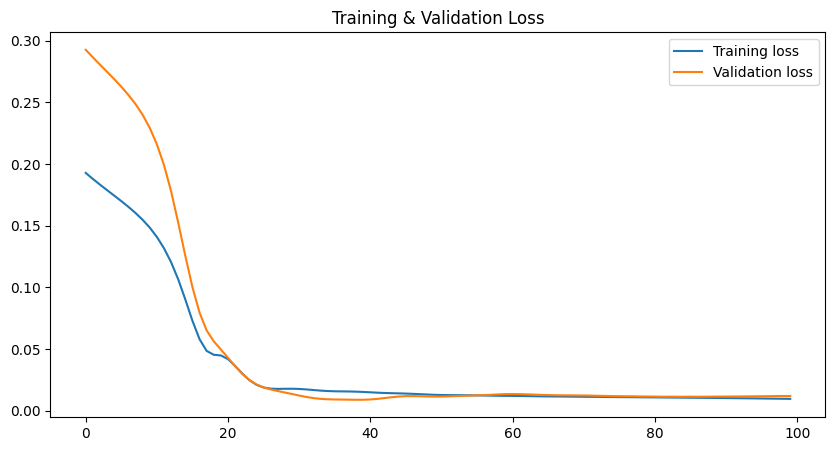

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_logger, label='Training loss')
plt.plot(val_loss_logger, label='Validation loss')
plt.title("Training & Validation Loss")
plt.legend()

# Save the figure as a PNG file
plt.savefig("./Results/Loss_{}.png".format(datasets[dataset_idx]))

plt.show()

### 5. Model prediction

#### 5.1 Predict previous dates for compariosn and visualization

In [119]:
lstm.eval()

# Predict previous dates for compariosn and visualization
train_predict = lstm(df_X_ss) # forward pass
last_predict = lstm(X_pred_tensors_final)

data_predict = train_predict.data.numpy().reshape(-1, y.shape[-1]) # numpy conversion
last_data_predict = last_predict.data.numpy().reshape(-1, y.shape[-1])
dataY_plot = df_y_mm.data.numpy().reshape(-1, y.shape[-1])

data_predict = mm.inverse_transform(data_predict) # reverse transformation
last_data_predict = mm.inverse_transform(last_data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)

true = np.concatenate((dataY_plot[::10], dataY_plot[-9:]), axis=0)
preds = np.concatenate((data_predict[::10], last_data_predict[::10]), axis=0)

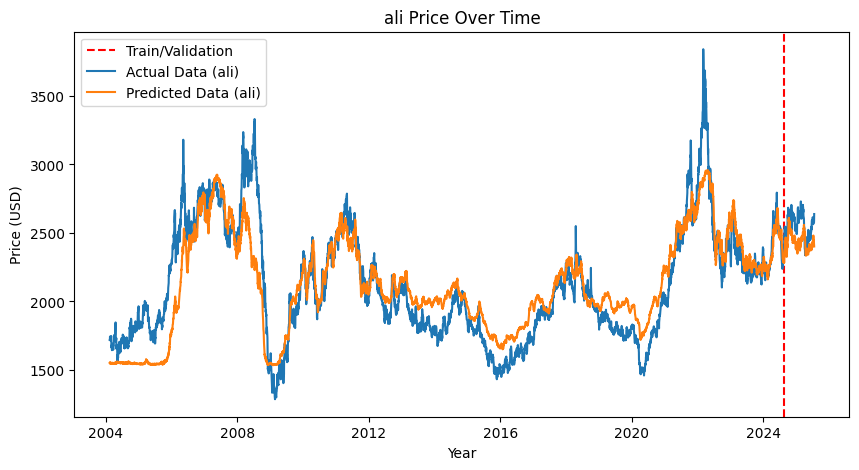

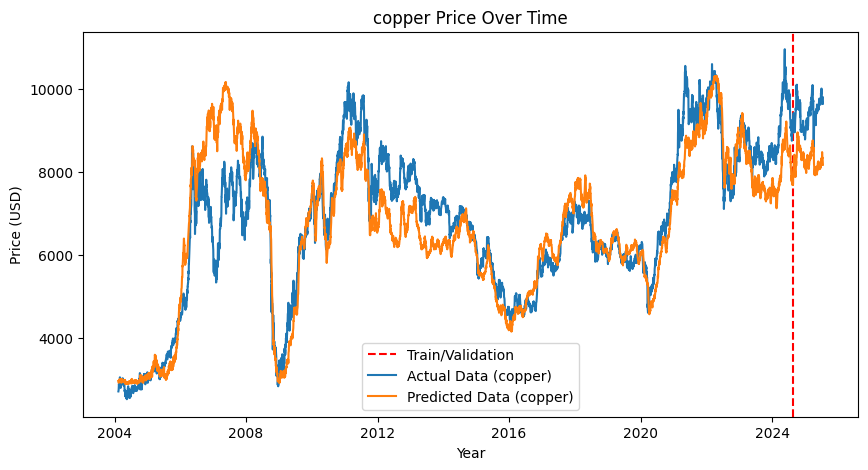

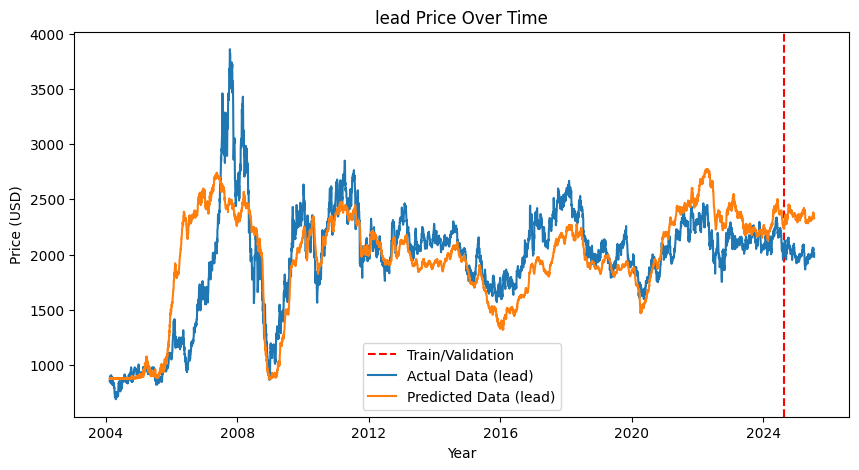

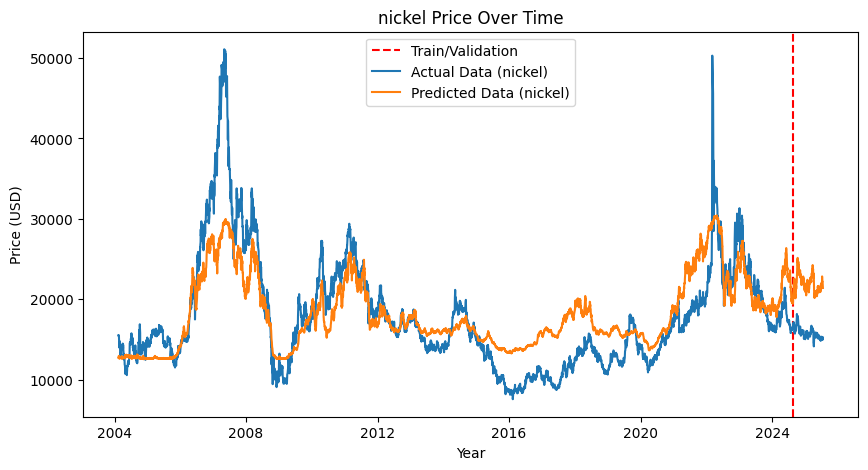

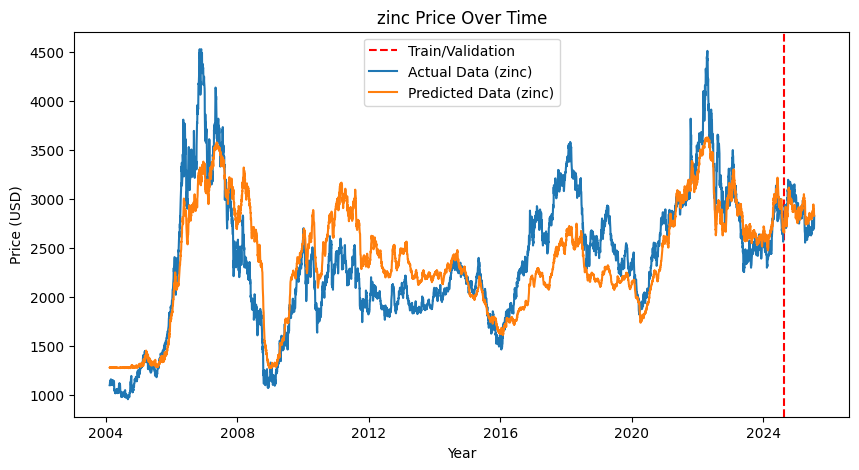

In [126]:
for idx, metal in enumerate(datasets):
    plt.figure(figsize=(10,5))
    plt.axvline(df.index[-len(y_test)], c='r', linestyle='--', label='Train/Validation')
    plt.plot(df.index[-len(true):], true[:, idx], label='Actual Data ({})'.format(metal)) # actual plot
    plt.plot(df.index[-len(true):], preds[:, idx], label='Predicted Data ({})'.format(metal)) # predicted plot
    plt.xlabel("Year")
    plt.ylabel("Price (USD)")
    plt.title("{} Price Over Time".format(metal))
    plt.legend()

    plt.show()

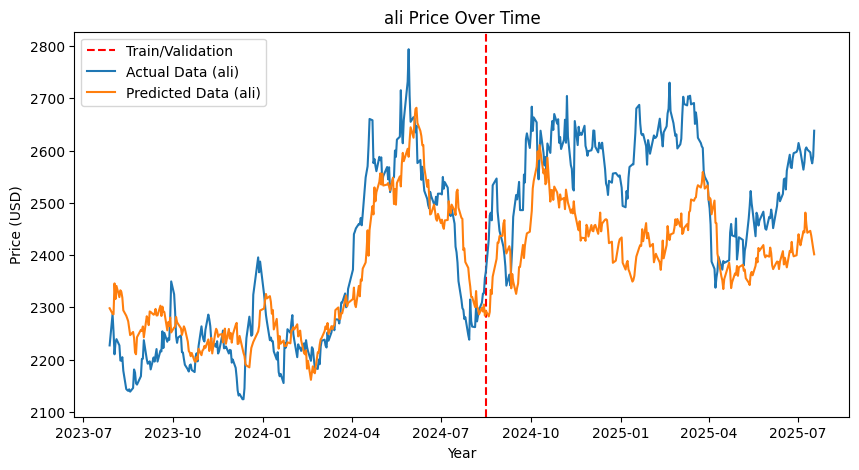

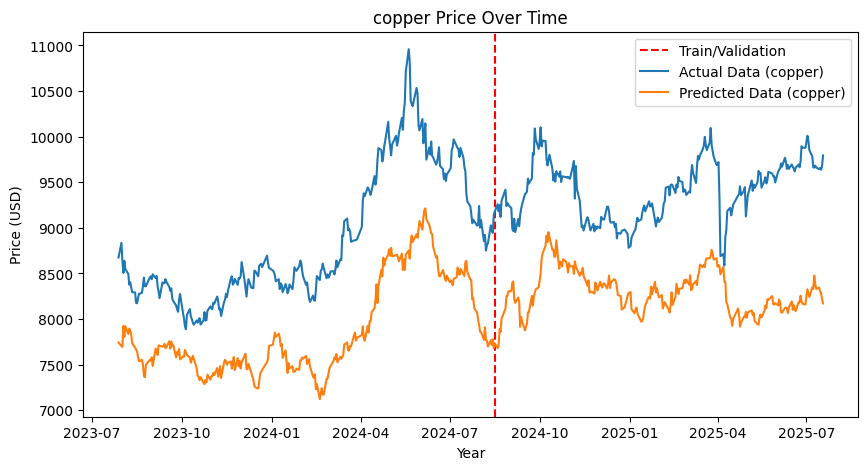

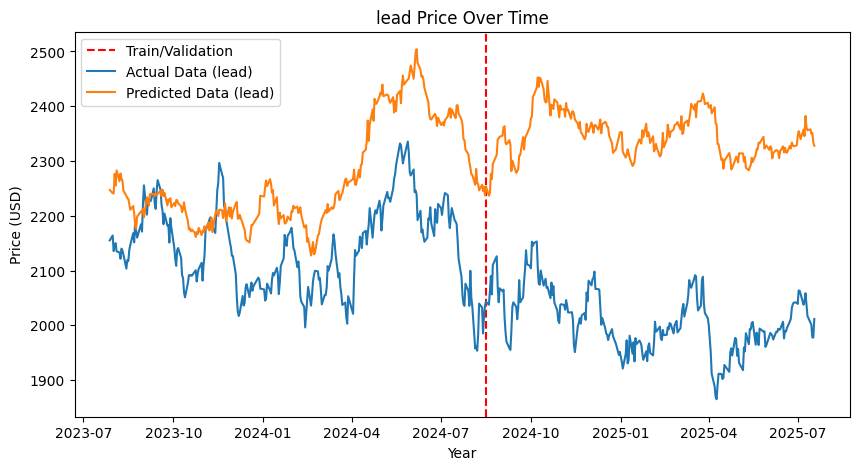

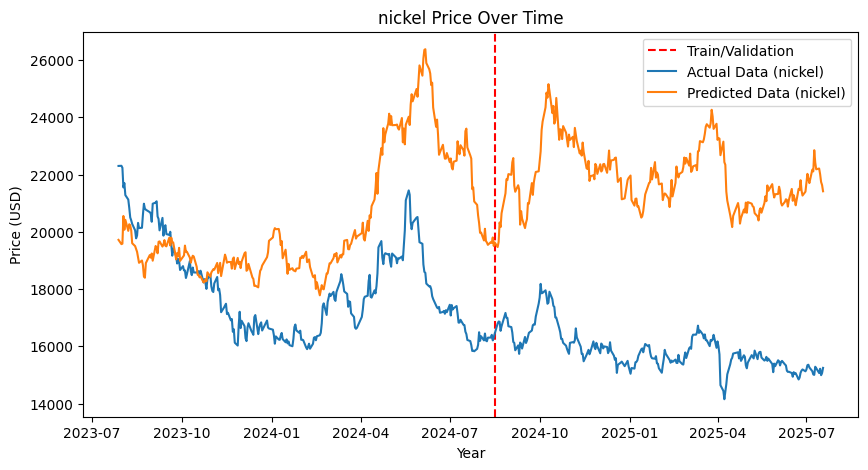

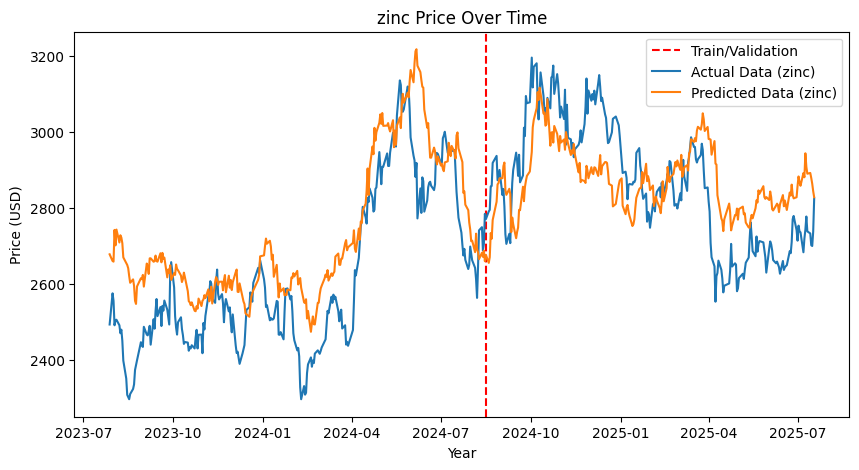

In [127]:
for idx, metal in enumerate(datasets):
    plt.figure(figsize=(10,5))
    plt.axvline(df.index[-len(y_test)], c='r', linestyle='--', label='Train/Validation')
    plt.plot(df.index[-500:], true[-500:, idx], label='Actual Data ({})'.format(metal)) # actual plot
    plt.plot(df.index[-500:], preds[-500:, idx], label='Predicted Data ({})'.format(metal)) # predicted plot
    plt.xlabel("Year")
    plt.ylabel("Price (USD)")
    plt.title("{} Price Over Time".format(metal))
    plt.legend()

    plt.show()

In [25]:
# Save the model's state_dict
PATH = "./Model/LSTM_with_Indicators.pth"
torch.save(lstm.state_dict(), PATH)

#### 5.2 Predict prices of future 10 days

In [105]:
# Instantiate the model
lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

# Load the saved state_dict
PATH = "./Model/LSTM_with_Indicators.pth"
lstm.load_state_dict(torch.load(PATH))

# Set the model to evaluation mode (important for inference)
lstm.eval()

LSTM(
  (lstm1): LSTM(23, 64, num_layers=2, batch_first=True)
  (lstm2): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [135]:
# predict prices of future 10 days
lstm.eval()

test_predict = lstm(X_last_tensor_final)
test_predict = test_predict.detach().numpy().reshape(-1, y.shape[-1])
test_predict = mm.inverse_transform(test_predict)

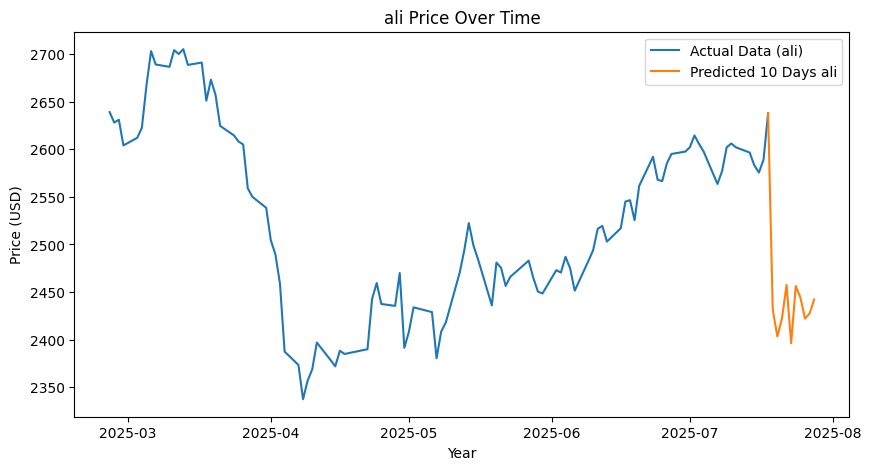

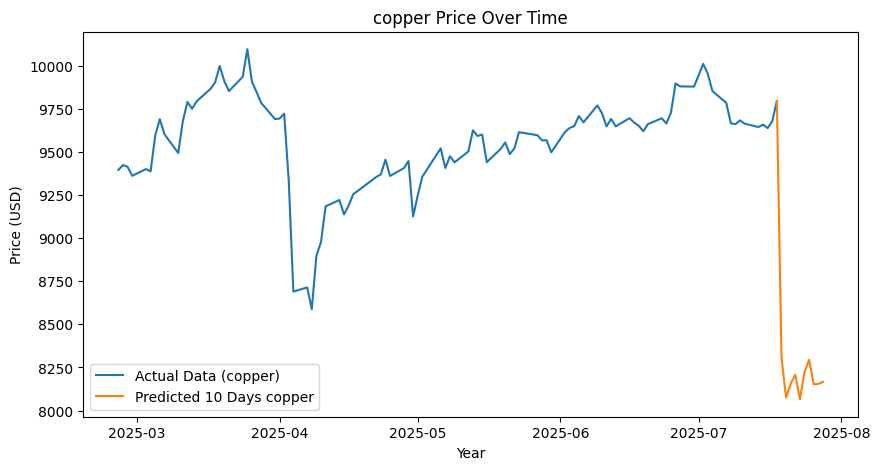

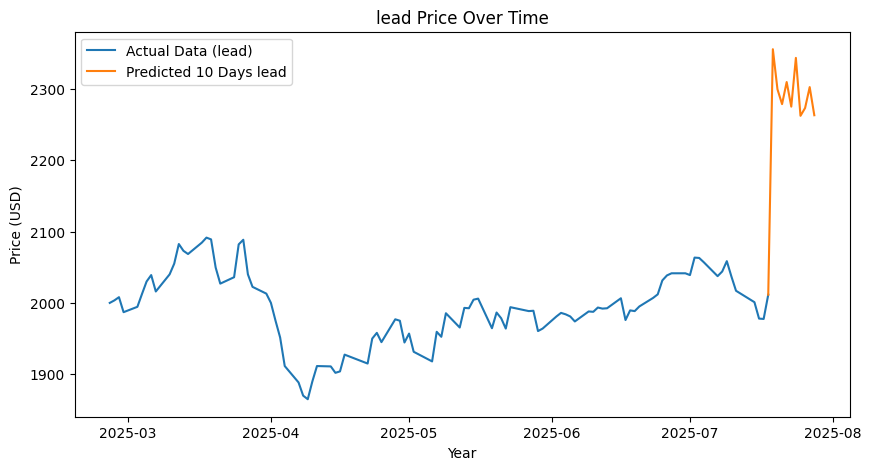

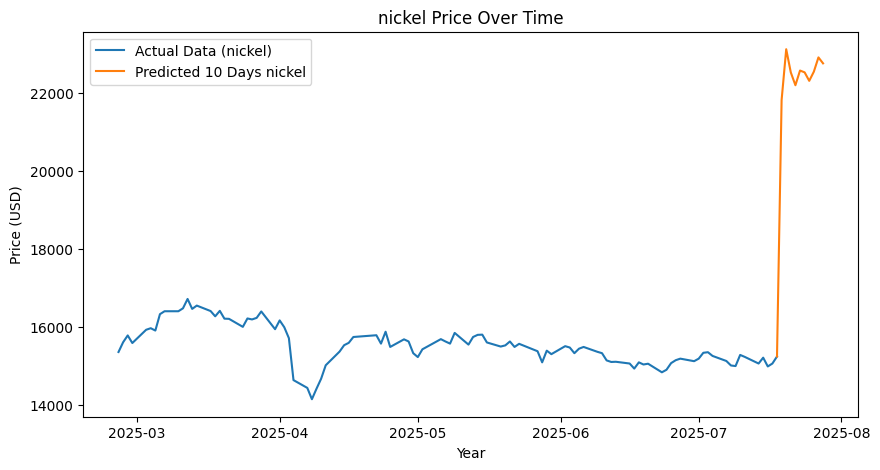

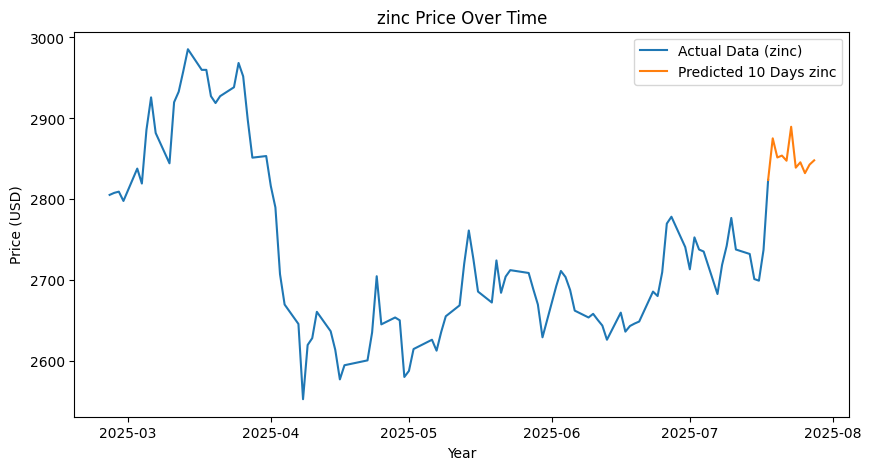

In [138]:
for idx, metal in enumerate(datasets):
    plt.figure(figsize=(10,5))
    plt.plot(df.index[-100:], df['PX_LAST_{}'.format(metal)].iloc[-100:], label='Actual Data ({})'.format(metal)) # actual plot
    plt.plot([df.index[-1] + datetime.timedelta(days=i) for i in range(11)], 
             [df['PX_LAST_{}'.format(metal)].iloc[-1]] + list(test_predict[:, idx]), label='Predicted 10 Days {}'.format(metal))
    plt.xlabel("Year")
    plt.ylabel("Price (USD)")
    plt.title("{} Price Over Time".format(metal))
    plt.legend()

    plt.show()

In [168]:
df_output = pd.DataFrame(np.concatenate((df[['PX_LAST_{}'.format(metal) for metal in datasets]].iloc[-1:, :].values, test_predict), axis=0))
df_output.columns = ['PX_LAST_{}'.format(metal) for metal in datasets]
df_output['Date'] = [df.index[-1] + datetime.timedelta(days=i) for i in range(11)]
df_output.set_index('Date', drop=True, inplace=True)

df_output.to_csv('./Results/Prediction_all.csv', index=True)